In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


struktura folderów w google drive, żeby zaczytało dane

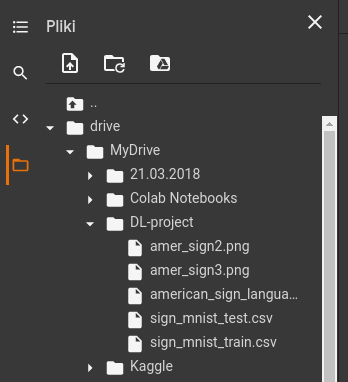

In [ ]:
class Model():
  '''
  Each successive line contians 785 comma separated values between 0 and 255
  The first value is the label
  The rest are the pixel values for that picture
  The function, that will return 2 np.array types.
  One with all the labels and other with all the images
  '''

  def __init__(self):
    def get_data(filename):
      with open(filename) as training_file:
        training_reader = csv.reader(training_file, delimiter=',')
        image = []
        labels = []
        line_count = 0
        for row in training_reader:
            if line_count == 0:
                line_count +=1
            else:
                labels.append(row[0])
                temp_image = row[1:785]
                image_data_as_array = np.array_split(temp_image, 28)
                image.append(image_data_as_array)
                line_count += 1
        images = np.array(image).astype('float')
        labels = np.array(labels).astype('float')
        print(f'Processed {line_count} lines.')
      return images, labels

    self.training_images, self.training_labels = get_data("/content/drive/MyDrive/DL-project/sign_mnist_train.csv")
    self.testing_images, self.testing_labels = get_data("/content/drive/MyDrive/DL-project/sign_mnist_test.csv")

    print("Total Training images", self.training_images.shape)
    print("Total Training labels",self.training_labels.shape)
    print("Total Testing images",self.testing_images.shape)
    print("Total Testing labels",self.testing_labels.shape)

    #Data Augmentation
    self.training_images = np.expand_dims(self.training_images, axis = 3)
    self.testing_images = np.expand_dims(self.testing_images, axis = 3)

    # Create an ImageDataGenerator and do Image Augmentation
    self.train_datagen = ImageDataGenerator(rescale=1. / 255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
      )

    self.validation_datagen = ImageDataGenerator(rescale=1. / 255 )

    self.train_gen = self.train_datagen.flow(
      self.training_images,
      self.training_labels,
      batch_size=20
    )

    self.val_gen = self.validation_datagen.flow(
      self.testing_images,
      self.testing_labels,
      batch_size=20
    )

  #function which plots sign using row number    
  def show_image(self, row_number):
    img = self.training_images[row_number][:].reshape(28,28)
    fig = plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.title("Picture of sign")
    plt.show()
  
  #function which plots accuracy and loss
  def show_results(self):


    #function for creating model with some hiperparametrs
    #def create_model():

    #complite the model
    #model.compile(...)

    #use the train_gen and val_gen when fiting the model
    # Train the Model
    '''
    self.history = model.fit_generator(train_gen,
        epochs=20,
        validation_data=val_gen)

    model.evaluate(testing_images, testing_labels, verbose=0)
    '''

    

In [ ]:
model=Model()

Processed 27456 lines.
Processed 7173 lines.
Total Training images (27455, 28, 28)
Total Training labels (27455,)
Total Testing images (7172, 28, 28)
Total Testing labels (7172,)


In [ ]:
model.show_image(18)